# Skin Disease Diagnosis and Analysis CNN Based

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [2]:
np.random.seed(42)
from sklearn.metrics import confusion_matrix

In [3]:
# CNN  ---- Tensorflow

# Python 3.10.8

import keras
from keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [4]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')
skin_df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [5]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [6]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

C:\Users\jagdi\AppData\Local\Temp\ipykernel_46600\3885637716.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


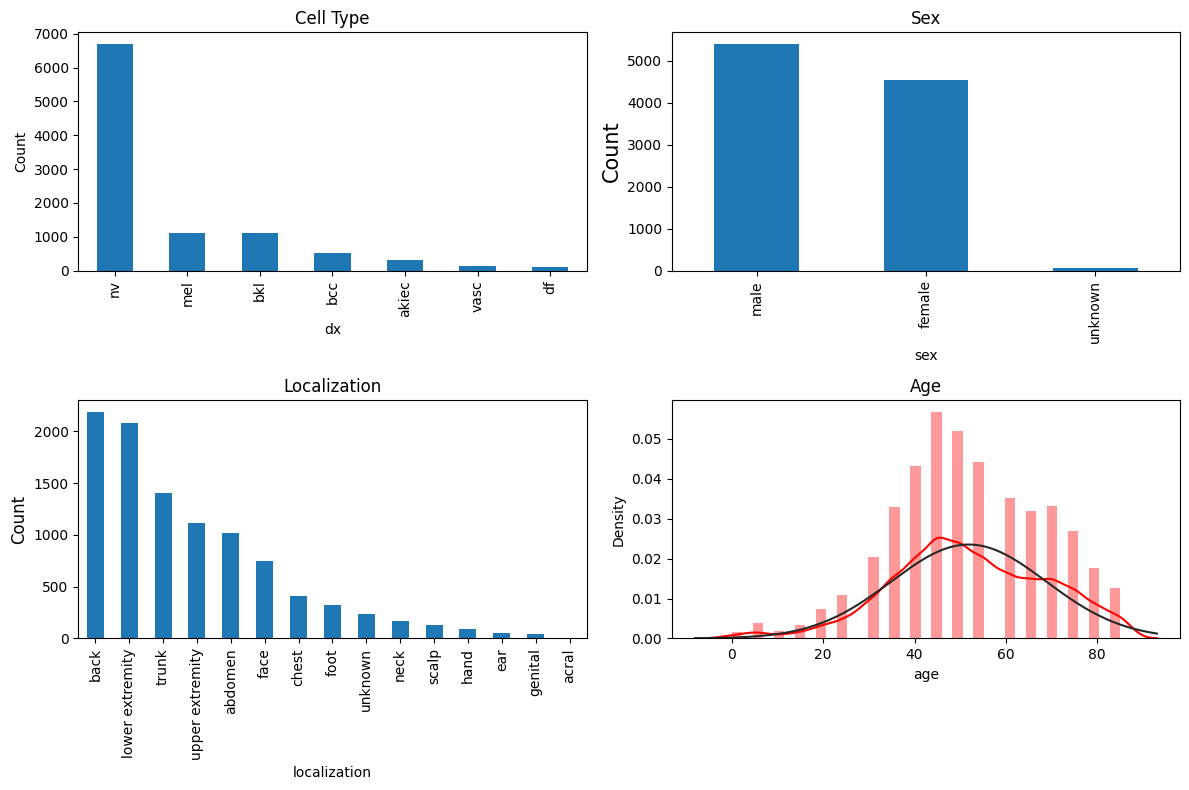

In [7]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [8]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [9]:
print(skin_df['sex'].value_counts())

sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64


In [10]:
print(skin_df['localization'].value_counts())

localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


In [11]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]     #327
df_1 = skin_df[skin_df['label'] == 1]     #514
df_2 = skin_df[skin_df['label'] == 2]     #1099
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [12]:
num=500 

df_0_balanced = resample(df_0, replace=True, n_samples=num, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=num, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=num, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=num, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=num, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=num, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=num, random_state=42)

In [13]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [14]:
skin_df_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0
...,...,...,...,...,...,...,...,...
2375,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,6
2436,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,6
2453,HAM_0001038,ISIC_0024706,vasc,consensus,50.0,male,trunk,6
2377,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,6


In [15]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [16]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/', '*', '*.jpg'))}

In [17]:
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
skin_df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,data\HAM10000_images_part_1\ISIC_0026645.jpg
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,data\HAM10000_images_part_1\ISIC_0025780.jpg
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,data\HAM10000_images_part_1\ISIC_0024450.jpg
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,data\HAM10000_images_part_1\ISIC_0027896.jpg
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,data\HAM10000_images_part_1\ISIC_0029268.jpg


In [18]:
SIZE=32
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))
skin_df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,data\HAM10000_images_part_1\ISIC_0026645.jpg,"[[[155, 118, 107], [162, 126, 118], [174, 140,..."
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,data\HAM10000_images_part_1\ISIC_0025780.jpg,"[[[138, 76, 82], [131, 64, 68], [139, 73, 81],..."
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,data\HAM10000_images_part_1\ISIC_0024450.jpg,"[[[123, 86, 87], [174, 137, 137], [197, 161, 1..."
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,data\HAM10000_images_part_1\ISIC_0027896.jpg,"[[[205, 149, 175], [207, 149, 169], [214, 158,..."
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,data\HAM10000_images_part_1\ISIC_0029268.jpg,"[[[203, 174, 199], [205, 174, 197], [206, 175,..."


In [19]:
skin_df_balanced.to_csv('file1.csv')

In [18]:
skin_df_balanced['image']

9789    [[[155, 118, 107], [162, 126, 118], [174, 140,...
9957    [[[138, 76, 82], [131, 64, 68], [139, 73, 81],...
9793    [[[123, 86, 87], [174, 137, 137], [197, 161, 1...
9758    [[[205, 149, 175], [207, 149, 169], [214, 158,...
9875    [[[203, 174, 199], [205, 174, 197], [206, 175,...
                              ...                        
2375    [[[15, 12, 12], [40, 30, 32], [87, 67, 71], [1...
2436    [[[148, 109, 118], [121, 93, 102], [112, 87, 9...
2453    [[[248, 181, 199], [248, 183, 201], [248, 186,...
2377    [[[180, 133, 143], [189, 147, 158], [192, 150,...
2363    [[[192, 174, 169], [197, 179, 175], [200, 179,...
Name: image, Length: 3500, dtype: object

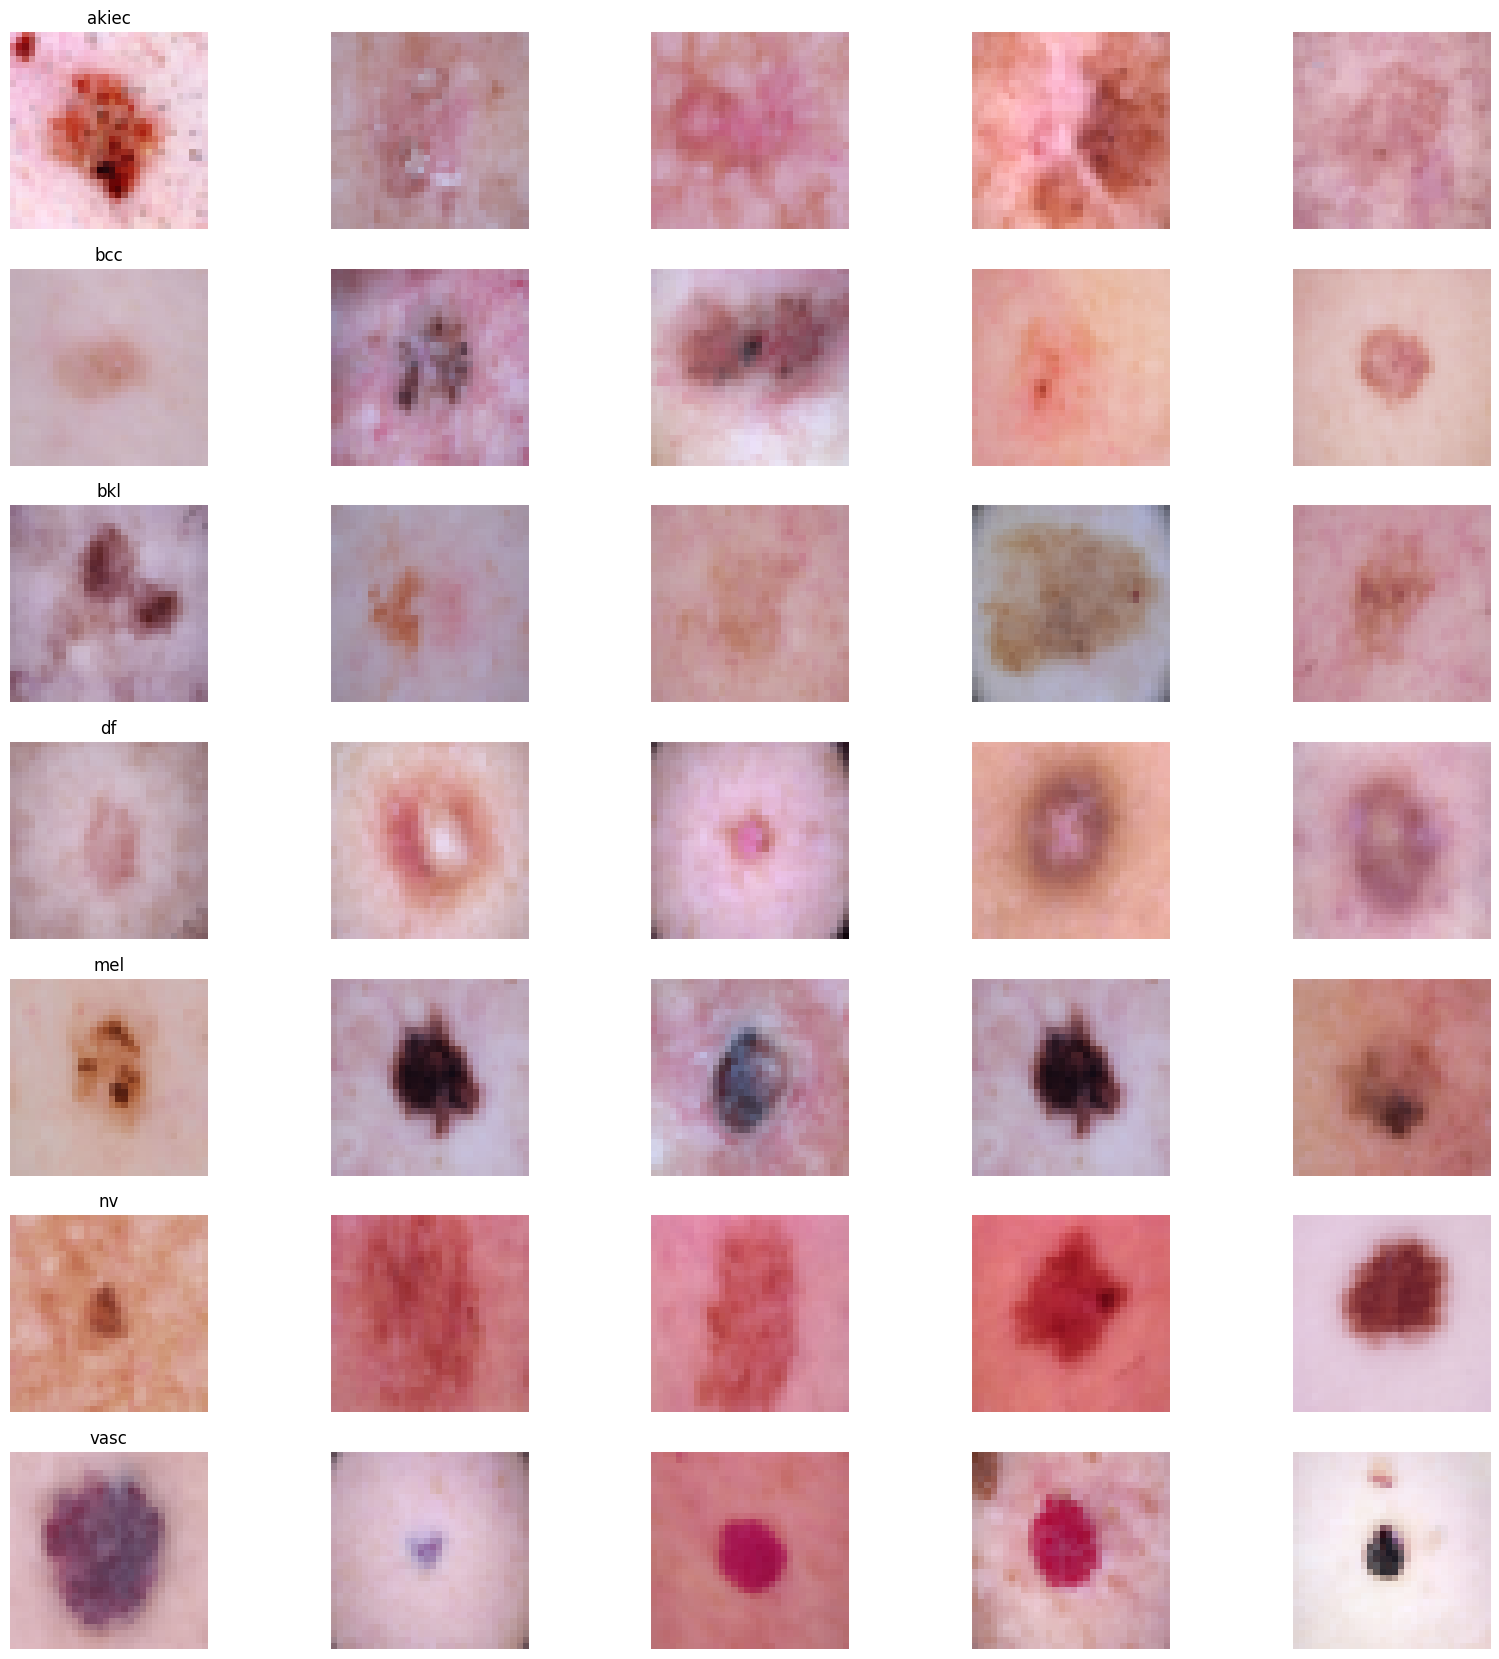

In [19]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [20]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
X.shape

(3500, 32, 32, 3)

In [21]:
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
Y_cat.shape

(3500, 7)

# Train Test Split

In [22]:
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

# Keras Model

In [23]:
#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [25]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/50


165/165 - 16s - loss: 1.8873 - acc: 0.1954 - val_loss: 1.7826 - val_acc: 0.2686 - 16s/epoch - 97ms/step
Epoch 2/50
165/165 - 12s - loss: 1.6313 - acc: 0.3250 - val_loss: 1.5254 - val_acc: 0.3680 - 12s/epoch - 74ms/step
Epoch 3/50
165/165 - 13s - loss: 1.4973 - acc: 0.3840 - val_loss: 1.5532 - val_acc: 0.4057 - 13s/epoch - 79ms/step
Epoch 4/50
165/165 - 12s - loss: 1.4392 - acc: 0.4103 - val_loss: 1.3782 - val_acc: 0.4389 - 12s/epoch - 74ms/step
Epoch 5/50
165/165 - 13s - loss: 1.3764 - acc: 0.4526 - val_loss: 1.3276 - val_acc: 0.4594 - 13s/epoch - 77ms/step
Epoch 6/50
165/165 - 12s - loss: 1.3415 - acc: 0.4720 - val_loss: 1.3481 - val_acc: 0.4309 - 12s/epoch - 74ms/step
Epoch 7/50
165/165 - 12s - loss: 1.2941 - acc: 0.5010 - val_loss: 1.2775 - val_acc: 0.4731 - 12s/epoch - 72ms/step
Epoch 8/50
165/165 - 12s - loss: 1.2544 - acc: 0.5021 - val_loss: 1.2968 - val_acc: 0.4754 - 12s/epoch - 73ms/step
Epoch 9/50
165/165 - 12s - loss: 1.2276 - acc: 0.5090 - val_loss: 1.1874 - val

In [26]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 1s 35ms/step - loss: 0.7977 - acc: 0.7280
Test accuracy: 0.7279999852180481


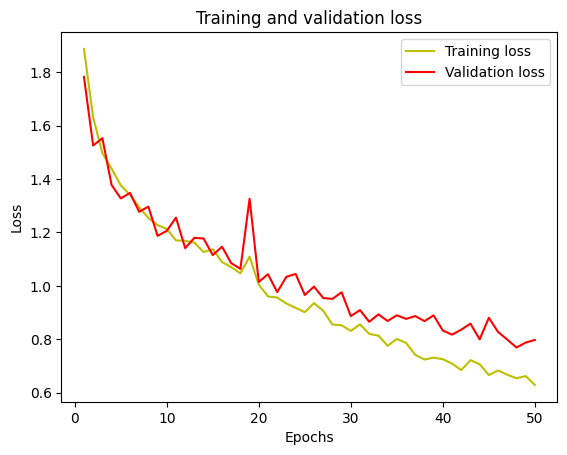

In [27]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

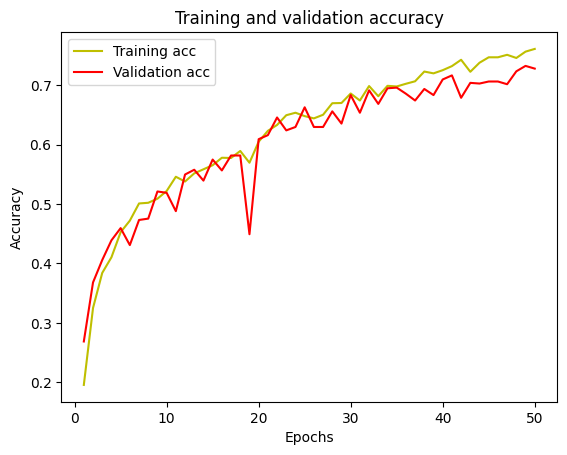

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk

In [30]:
def upload_diagnose_file():
    global img
    global filename
    global val
    f_types = [('Jpg Files', '*.jpg')]
    l3.config(text="Disease")
    filename = filedialog.askopenfilename(filetypes=f_types)
    img=Image.open(filename)
    img_resized=img.resize((400,200)) # new width & height
    img=ImageTk.PhotoImage(img_resized)
    b2 =tk.Button(my_w,image=img) # using Button 
    #b2.grid(row=3,column=1)
    b2.place(x=450,y=320)
    f = filename.split("/")
    f2=f[-1]
    fl = f2.split(".")
    fnl = fl[0]
    val2="abc"
    for ind in skin_df.index:
        if str(skin_df['image_id'][ind]) == fnl:
            val2=str(skin_df['dx'][ind])
    
    pth=filename
    #pth = 'data\HAM10000_images_part_1\ISIC_0025195.jpg'
    # initialize list elements 
    data = [pth] 

    
    
    
    # Create the pandas DataFrame with column name is provided explicitly 
    df = pd.DataFrame(data, columns=['Path']) 
  
    # print dataframe. 

    filename
    df['image'] = df['Path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))
    #Convert dataframe column of images into numpy array
    target_X = np.asarray(df['image'].tolist())
    target_X = target_X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.

    # Prediction on test data
    #y_pred = model.predict(x_test)
    y_pred = model.predict(target_X)
    y_pred

    # Convert predictions classes to one hot vectors 
    y_pred_classes = np.argmax(y_pred, axis = 1)
    y_pred_classes
    df_new = skin_df_balanced[skin_df_balanced['label'] == y_pred_classes[0]]
    valv=df_new['dx'].iloc[0]
    if val2==valv:
        val=valv
    else:
        val=val2
    

In [31]:
import mysql.connector

In [32]:
def dname():
    mydb = mysql.connector.connect(host="localhost",user="root",password="root",database="skin_disease_CNN")
    mycursor = mydb.cursor()
    mycursor.execute("SELECT disease FROM symptoms where dis_code='" + val + "'")
    myresult = mycursor.fetchall()
    for x in myresult:
        l3.config(text="Disease : " + str(x))

In [33]:
def symptoms():
    msg="Following are Symptoms \n"
    mydb = mysql.connector.connect(host="localhost",user="root",password="root",database="skin_disease_CNN")
    mycursor = mydb.cursor()
    mycursor.execute("SELECT symptoms FROM symptoms where dis_code='" + val + "'")
    myresult = mycursor.fetchall()
    i=1
    for x in myresult:
        msg = msg + str(i) + ":" + str(x) + "\n"
        i=i+1
    
    l4.config(text=msg)

In [34]:
def treatment():
    msg="Following are Treatments \n"
    mydb = mysql.connector.connect(host="localhost",user="root",password="root",database="skin_disease_CNN")
    mycursor = mydb.cursor()
    mycursor.execute("SELECT treatment FROM treatment where dis_code='" + val + "'")
    myresult = mycursor.fetchall()
    i=1
    for x in myresult:
        msg = msg + str(i) + ":" + str(x) + "\n"
        i=i+1
    
    l5.config(text=msg)

# Final GUI

In [35]:
my_w = tk.Tk()
my_w.configure(background='lavender')
my_w.geometry("900x750")  # Size of the window 
my_w.title('Skin Desease Diagnosis')
my_font1=('times', 14, 'bold')
my_font2=('times', 10, 'bold')

l1 = tk.Label(my_w,text='Add Skin Disease Photo',width=30,font=my_font1)  
#l1.grid(row=1,column=1)
l1.place(x=200,y=15)

b1 = tk.Button(my_w, text='Upload File', 
   width=20,command = lambda:upload_diagnose_file())
b1.place(x=20,y=50)

b2 = tk.Button(my_w, text='Diagnose', 
   width=20,command = dname)
b2.place(x=200,y=50)

b3 = tk.Button(my_w, text='Symptoms', 
   width=20,command = symptoms)
b3.place(x=400,y=50)

b4 = tk.Button(my_w, text='Treatment', 
   width=20,command = treatment)
b4.place(x=600,y=50)


l3 = tk.Label(my_w,text='Disease',width=30,font=my_font1)  
#l3.grid(row=5,column=1)
l3.place(x=20,y=100)

l4 = tk.Label(my_w,text='Symptoms',width=200,font=my_font2)  
#l3.grid(row=5,column=1)
l4.place(x=-300,y=150)

l5 = tk.Label(my_w,text='Treatment',width=100,font=my_font2)  
#l3.grid(row=5,column=1)
l5.place(x=100,y=550)

#b1.grid(row=2,column=1)
#b2.grid(row=2,column=2)

my_w.mainloop()  # Keep the window open





1/1 [==============================] - 0s 213ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\YASH\AppData\Local\Programs\Python\Python310\lib\site-packages\mysql\connector\network.py", line 509, in open_connection
    self.sock.connect(sockaddr)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\YASH\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\YASH\AppData\Local\Temp\ipykernel_28144\3243405884.py", line 2, in dname
    mydb = mysql.connector.connect(host="localhost",user="root",password="",database="disease")
  File "C:\Users\YASH\AppData\Local\Programs\Python\Python310\lib\site-packages\mysql\connector\__init__.py", line 179, in connect
    return MySQLConnection(*args, **kwargs)
  File "C:\Users\YASH\AppData\Local\Programs

1/1 [==============================] - 0s 26ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\YASH\AppData\Local\Programs\Python\Python310\lib\site-packages\mysql\connector\network.py", line 509, in open_connection
    self.sock.connect(sockaddr)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\YASH\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\YASH\AppData\Local\Temp\ipykernel_28144\2908442696.py", line 3, in symptoms
    mydb = mysql.connector.connect(host="localhost",user="root",password="",database="disease")
  File "C:\Users\YASH\AppData\Local\Programs\Python\Python310\lib\site-packages\mysql\connector\__init__.py", line 179, in connect
    return MySQLConnection(*args, **kwargs)
  File "C:\Users\YASH\AppData\Local\Progr